In [86]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings('ignore')

train_tsv = pd.read_csv("./data/NIPA_train.tsv", delimiter='\t', header=None)
test_tsv = pd.read_csv("./data/NIPA_test.tsv", delimiter='\t', header=None)
train_tsv

,0,1,2
0,3_5_1123.jpg,3,5
1,3_20_1048.jpg,3,20
2,4_2_401.jpg,4,2
3,4_7_740.jpg,4,7
4,4_11_93.jpg,4,11
...,...,...,...
15995,13_15_1600.jpg,13,15
15996,13_16_1570.jpg,13,16
15997,13_17_986.jpg,13,17
15998,13_18_4980.jpg,13,18


In [112]:
test_tsv

,0
0,0.jpg
1,1.jpg
2,2.jpg
3,3.jpg
4,4.jpg
...,...
3992,3992.jpg
3993,3993.jpg
3994,3994.jpg
3995,3995.jpg


In [88]:
import os
from glob import glob
import tensorflow as tf
from PIL import Image # 주로 image 열 때
import matplotlib.pyplot as plt
%matplotlib inline

os.listdir('data/NIPA_train')

['10_20_1004.jpg',
 '10_20_1005.jpg',
 '10_20_1021.jpg',
 '10_20_1035.jpg',
 '10_20_1048.jpg',
 '10_20_1049.jpg',
 '10_20_105.jpg',
 '10_20_1051.jpg',
 '10_20_1054.jpg',
 '10_20_1059.jpg',
 '10_20_1064.jpg',
 '10_20_1066.jpg',
 '10_20_1069.jpg',
 '10_20_107.jpg',
 '10_20_1070.jpg',
 '10_20_1071.jpg',
 '10_20_1075.jpg',
 '10_20_109.jpg',
 '10_20_1094.jpg',
 '10_20_1095.jpg',
 '10_20_1097.jpg',
 '10_20_1098.jpg',
 '10_20_111.jpg',
 '10_20_1110.jpg',
 '10_20_1112.jpg',
 '10_20_1129.jpg',
 '10_20_1132.jpg',
 '10_20_1150.jpg',
 '10_20_1152.jpg',
 '10_20_1153.jpg',
 '10_20_116.jpg',
 '10_20_1160.jpg',
 '10_20_1161.jpg',
 '10_20_117.jpg',
 '10_20_1172.jpg',
 '10_20_1174.jpg',
 '10_20_1182.jpg',
 '10_20_1189.jpg',
 '10_20_1192.jpg',
 '10_20_12.jpg',
 '10_20_1216.jpg',
 '10_20_1218.jpg',
 '10_20_1222.jpg',
 '10_20_1224.jpg',
 '10_20_1228.jpg',
 '10_20_1233.jpg',
 '10_20_1234.jpg',
 '10_20_1238.jpg',
 '10_20_124.jpg',
 '10_20_1244.jpg',
 '10_20_1250.jpg',
 '10_20_1256.jpg',
 '10_20_1258.jpg',
 '

In [106]:
train_paths = glob('data/NIPA_train/*.jpg')
test_paths = glob('data/NIPA_test/*.jpg')
len(train_paths), len(test_paths)

(16000, 3997)

In [116]:
path = train_paths[0]
path

'data/NIPA_train\\10_20_1004.jpg'

(256, 256, 3)

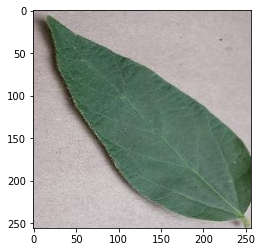

In [117]:
# 이미지 불러오기
from PIL import Image

img_pil = Image.open(path)
image = np.array(img_pil)
plt.imshow(image)
image.shape

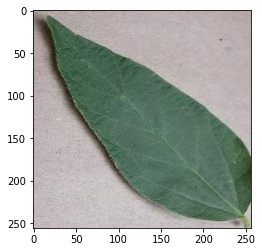

(256, 256, 3)

In [118]:
# tensorflow로 이미지 불러오기
def read_image(path):
    gfile = tf.io.read_file(path)
    image = tf.io.decode_image(gfile, dtype=tf.float32)
    return image

plt.imshow(read_image(train_paths[0]))
plt.show()

image.shape

In [92]:
# 이미지 라벨 얻기
def get_label(path):
    label_1 = np.int(path.split('\\')[1].split('_')[0])
    label_2 = np.int(path.split('\\')[1].split('_')[1])
    
    return label_1, label_2

## Batch
## Images in List
- image를 하나의 list로 묶어서, 하나의 array 또는 tensor로 만들어줘
- shape이 [256, 256, 3]인 image를 batch_size만큼 묶어서 또다른 하나의 데이터로 보게끔!
    - 그럼 shape 앞에 또다른 차원이 늘어나겠지

In [93]:
# list안의 데이터 모두를 하나의 데이터로 묶는 방법
def make_batch(batch_paths):
    batch_images = []

    for path in batch_paths[:8]:
        image = read_image(path)
        batch_images.append(image)

        # list안의 데이터 모두를 하나의 데이터로 묶는 방법
    return tf.convert_to_tensor(batch_images)

batch_images = make_batch(train_paths[:8])
batch_images.shape

TensorShape([8, 256, 256, 3])

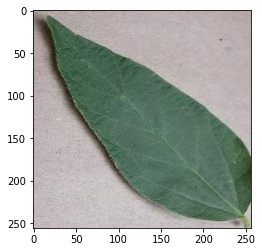

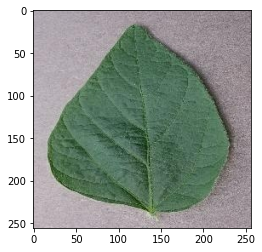

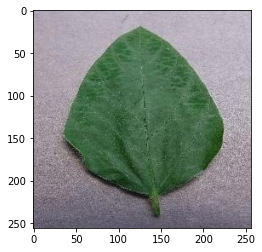

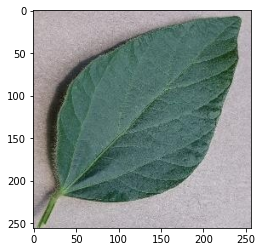

In [94]:
# 정해준 batch_size만큼 이미지 자르기
batch_size = 16
for step in range(4):
    batch_images = make_batch(train_paths[step * batch_size : (step + 1) * batch_size])
    plt.imshow(batch_images[0]) # 매 step의 첫 번째 이미지만 시각화
    plt.show()

## Set Data Generator
- image가 Data Generator를 거치면서 우리가 원하는 영상 전처리 실시됨
- Data Generator를 통해 Model에 데이터를 변환해서 넣어주는 것
     - ex) 서있는 고양이를 뒤집어져있거나, 누워있거나 등등 데이터를 다양하게 변화를 줘서 이미지를 학습

In [99]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    # 전처리 할 것들
    rotation_range=20, # 회전
    width_shift_range=0.2, # 좌우, image size의 0.2%만 random하게 움직임
    height_shift_range=0.2, # 상하
    horizontal_flip=True, # 뒤집음
    zoom_range=0.3 # 상하좌우로 늘림
)

inputs = image[tf.newaxis, ...]
inputs.shape # 4차원

(1, 256, 256, 3)

In [100]:
image = next(iter(datagen.flow(inputs))) # 우선 1개만
# flow를 꼭 해줘야 함 (무엇을 지나가게 할 건지)
image.shape

(1, 256, 256, 3)

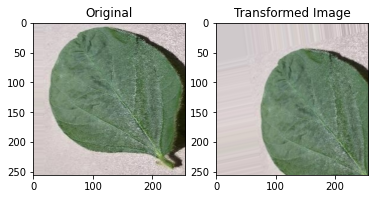

In [101]:
plt.subplot(121)
plt.title('Original')
plt.imshow(np.squeeze(inputs)) # np.squueze: 차원 중 사이즈가 1인 차원을 줄임
plt.subplot(122)
plt.title('Transformed Image')
plt.imshow(np.squeeze(image))
plt.show()

# Data Generator를 통해 이런 식으로 변화를 주어서 Model에 학습함

## Transformation
- width_shift_range  
- height_shift_range  
  
- brightness_range  
- zoom_range  
  
- horizontal_flip  
- vertical_flip  
  
- rescale  
  
- preprocessing_function 

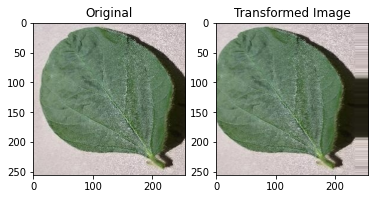

In [73]:
datagen = ImageDataGenerator(
    width_shift_range=0.3 
)

outputs = next(iter(datagen.flow(inputs)))

plt.subplot(121)
plt.title('Original')
plt.imshow(np.squeeze(inputs))

plt.subplot(122)
plt.title('Transformed Image')
plt.imshow(np.squeeze(outputs))
plt.show()

## Rescale시 주의사항
- rescale은 train과 test 둘 다 해주돼, **augmentation은 train만**해줘야 함

In [102]:
# train_datagen = ImageDataGenerator(
#     zoom_range=0.7,
#     rescale=1./255.
# )

# test_datagen = ImageDataGenerator(
#     rescale=1./255. # test는 rescale만 !
# )

In [119]:
from tensorflow.keras import layers
from tensorflow.keras import datasets 

In [137]:
train_tsv

,0,1,2
0,3_5_1123.jpg,3,5
1,3_20_1048.jpg,3,20
2,4_2_401.jpg,4,2
3,4_7_740.jpg,4,7
4,4_11_93.jpg,4,11
...,...,...,...
15995,13_15_1600.jpg,13,15
15996,13_16_1570.jpg,13,16
15997,13_17_986.jpg,13,17
15998,13_18_4980.jpg,13,18


In [136]:
np.sort(train_tsv[1].unique()) # 8개

array([ 3,  4,  5,  7,  8, 10, 11, 13], dtype=int64)

In [135]:
np.sort(train_tsv[2].unique()) # 14개

array([ 1,  2,  5,  6,  7,  8,  9, 11, 14, 15, 16, 17, 18, 20],
      dtype=int64)

## Hyperparameter Tunning

In [138]:
num_epochs = 10
batch_size = 32

learning_rate = 0.001

dropout_rate = 0.7

input_shape = (256, 256, 3)
num_class1 = 8
num_class2 = 14

In [154]:
class1_list = []
class2_list = []

for path in train_paths:
    class1, class2 = get_label(path)
    class1_list.append(class1)
    class2_list.append(class2)

In [155]:
data = {'name':train_paths, 'class1':class1_list, 'class2':class2_list}
train_df = pd.DataFrame(data)
train_df # train set

,name,class1,class2
0,data/NIPA_train\10_20_1004.jpg,10,20
1,data/NIPA_train\10_20_1005.jpg,10,20
2,data/NIPA_train\10_20_1021.jpg,10,20
3,data/NIPA_train\10_20_1035.jpg,10,20
4,data/NIPA_train\10_20_1048.jpg,10,20
...,...,...,...
15995,data/NIPA_train\8_9_995.jpg,8,9
15996,data/NIPA_train\8_9_996.jpg,8,9
15997,data/NIPA_train\8_9_997.jpg,8,9
15998,data/NIPA_train\8_9_998.jpg,8,9


In [ ]:
# generator 생성

batch_size = 16

# 학습 이미지에 적용한 augmentation 인자를 지정해줍니다.
train_datagen = ImageDataGenerator(
        rescale=1./255,
        width_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# 검증 및 테스트 이미지는 augmentation을 적용하지 않습니다.
# 모델 성능을 평가할 때에는 이미지 원본을 사용합니다.
validation_datagen = ImageDataGenerator(
    rescale=1./255
)
test_datagen = ImageDataGenerator(
    rescale=1./255
)

# 이미지를 배치 단위로 불러와 줄 generator입니다.
train_generator = train_datagen.flow_from_directory(
        train_df, 
        target_size=input_shape[:2],
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
        `data/validation`,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        `data/validation`,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')

In [141]:
train_generator = train_datagen.flow_from_dataframe(
    train_tsv,
    x_col=0,
    y_col=1,
    target_size=input_shape[:2],
    batch_size=batch_size
)

# validation_generator = test_datagen.flow_from_dataframe(
#     test_df,
#     x_col='0',
#     y_col='class',
#     target_size=input_shape[:2],
#     batch_size=batch_size
# )

TypeError: If class_mode="categorical", y_col="1" column values must be type string, list or tuple.

In [ ]:
from sklearn.metrics import recall_score 
from sklearn.metrics import precision_score 
from sklearn.metrics import f1_score

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(3, 150, 150)))
model.add(Activation(`relu`))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation(`relu`))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation(`relu`))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # 이전 CNN 레이어에서 나온 3차원 배열은 1차원으로 뽑아줍니다
model.add(Dense(64))
model.add(Activation(`relu`))
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation(`sigmoid`))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
            metrics=['accuracy', precision, recall, f1score])  )

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc',f1_m,precision_m, recall_m])

# fit the model
history = model.fit(Xtrain, ytrain, validation_split=0.3, epochs=10, verbose=0)

# evaluate the model
loss, accuracy, f1_score, precision, recall = model.evaluate(Xtest, ytest, verbose=0)